<center> <h1> The Battle of Neighborhood </h1><a name = 'top'></a>

## Table of Contents
* [Install Necessary Library](#install)
* [Import Library](#import)
* [Web Scraping](#scraping)
    * [Create Dataframe](#dataframe)
    * [Save Dataframe to CSV](#savetocsv)
    * [Visualize the Data](#montrealmap)
* [Foursquare](#foursquare)
    * [Save Foursquare Data to CSV](#savecsv)
* [Clustering and Analysis](#clustering)
    * [Onehot Encoding](#onehot)
    * [Apply the Clustering](#applycluster)
    * [Visualize the Cluster](#visualcluster)
    * [Analyze the Cluster](#analyzecluster)
    * [Analyze the Result](#analyzeresult)
* [Heatmap of the Clusters](#heatmap)
* [Asian Heat Map](#asianheatmap)
* [Final Neighborhood For Recommendation](#finalneighborhood)
* [Conclusion](#conclusion)

<h2> Install the Necessary Library </h2><a name='install'></a>

In [1]:
!pip install beautifulsoup4
!pip install lxml
!pip install googlemaps

<h2> Import All Necessary Library </h2><a name = 'import'></a>

[Table of Contents](#top)

In [1]:
import numpy as np
import requests
import lxml.html as lh
import pandas as pd
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import googlemaps

from bs4 import BeautifulSoup

<h2> Get Postcode, Borough, Neighborhood, Longitude and Latitude </h2><a name = 'scraping'></a>

[Table of Contents](#top)

### We create a dictionary out of this process

#### We will build the factors that will affect our decisions:
* number of existing restaurants in Montreal
* number of and distance to any Asian Restaurant, or if none, we will investigate if it is the right place
* distance of each neighborhood

#### In this project we will:
* Scrape the data from 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H'
* Then we will get the borough, neighborhood and postalcodes.
* Then we will use googlemap to get the longitude and latitude of each borough.

The code below is the one I use to put the Latitude and Longitude of each Neighborhood

```python
key = "your_googlemap_key"

from collections import defaultdict

source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H').text
soup = BeautifulSoup(source, 'html.parser')
gmaps = googlemaps.Client(key = key)

postal_codes_dict = defaultdict(dict) # initialize an empty dictionary to save the data in
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postal_codes_dict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
                neighborhoods_clean = neighborhoods_clean.strip('\n')
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
                
            #googlemaps for longitude and latitude of borough
            geocode_result = gmaps.geocode('{}, QC'.format(neighborhoods_clean))
            latlong = geocode_result[0]['geometry']['location']
            latitude = latlong["lat"]
            longitude = latlong['lng']
 
            # add borough and neighborhood to dictionary
            postal_codes_dict[postal_code]['borough'] = borough
            postal_codes_dict[postal_code]['neighborhoods'] = neighborhoods_clean
            postal_codes_dict[postal_code]['latitude'] = latitude
            postal_codes_dict[postal_code]['longitude'] = longitude
            
    except:
        pass
```

<h2> Create the Dataframe </h2><a name = 'dataframe'></a>

[Table of Contents](#top)

Below code creates the Data Frame of wha twe need.

```python
# create an empty dataframe
columns = ['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']
montreal_data = pd.DataFrame(columns=columns)

# populate dataframe with data from dictionary
for key, val in postal_codes_dict.items():
    
    try:
        borough = val['borough']
        neighborhood = val['neighborhoods']
        latitude = val['latitude']
        longitude = val['longitude']
        
        
    except KeyError:
        
        borough = ''
        neighborhood = ''
        latitude = ''
        longitude = ''
        
    montreal_data = montreal_data.append({"PostalCode": key, 
                                        "Borough": borough, 
                                        "Neighborhood": neighborhood,
                                         "Latitude": latitude,
                                         "Longitude": longitude},
                                        ignore_index=True)

#preview the data
montreal_data
```

|PostalCode|       Borough                |Neighborhood                |Latitude |Longitude|
| --- | --- | --- | --- | --- |
|H1A       |Pointe-aux-Trembles           |Pointe-aux-Trembles         |45.6417  |-73.5004 |
|H2A       |Saint-MichelEast              |Saint-MichelEast            |52.9399  |-73.5491 |
|H3A       |Downtown MontrealNorth        |McGill University           |45.5048  |-73.5772 |
|H4A       |Notre-Dame-de-GrâceNortheast  |Notre-Dame-de-GrâceNortheast|45.4652  |-73.6322 |
|H5A       |Place Bonaventure             |Place Bonaventure           |45.4994  |-73.565  |



124 rows × 5 columns


<h2> Save the Dataframe as CSV </h2><a name = 'savetocsv'></a>

[Table of Contents](#top)

This will save us time going to the process again if ever we close the Notebook
<br></br>

In [8]:
montreal_data.to_csv(r'montrealData.csv')

In [2]:
df_montreal = pd.read_csv('montrealData.csv')

In [3]:
df_montreal.head(10)

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,0,H1A,Pointe-aux-Trembles,Pointe-aux-Trembles,45.641666,-73.500401
1,1,H2A,Saint-MichelEast,Saint-MichelEast,52.939916,-73.549136
2,2,H3A,Downtown MontrealNorth,McGill University,45.504785,-73.577151
3,3,H4A,Notre-Dame-de-GrâceNortheast,Notre-Dame-de-GrâceNortheast,45.465174,-73.632219
4,4,H5A,Place Bonaventure,Place Bonaventure,45.499444,-73.565000
5,5,H7A,Duvernay-Est,Duvernay-Est,45.647219,-73.615238
6,6,H9A,Dollard-des-OrmeauxNorthwest,Dollard-des-OrmeauxNorthwest,45.489564,-73.820557
7,7,H1B,Montreal East,Montreal East,45.632000,-73.506698
8,8,H2B,AhuntsicNorth,AhuntsicNorth,45.555235,-73.668203
9,9,H3B,Downtown MontrealEast,Downtown MontrealEast,45.503480,-73.568489


In [4]:
df_montreal = df_montreal.dropna() #drop nan values

In [5]:
df_montreal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 123
Data columns (total 6 columns):
Unnamed: 0      123 non-null int64
PostalCode      123 non-null object
Borough         123 non-null object
Neighborhood    123 non-null object
Latitude        123 non-null float64
Longitude       123 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 6.7+ KB


<h2> Visualize the Montreal Postcode Data </h2><a name = 'montrealmap' ></a>

[Table of Contents](#top)

In [6]:
map_mont = folium.Map(location=[45.508888, -73.561668], zoom_start=11)

for lat,lng,borough,neighborhood in zip(df_montreal['Latitude'],df_montreal['Longitude'],df_montreal['Borough'],df_montreal['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,lng],
                        radius = 5,
                        popup = label,
                        color = 'blue',
                        fill = True,
                        fill_color = '#3186cc',
                        fill_opacity = 0.75,
                        parse_html=False).add_to(map_mont)
    
map_mont

<h2> Foursquare </h2><a name = 'foursquare' ></a>

[Table of Contents](#top)

Below is the code I use to get the venues on each neighborhood

```python
CLIENT_ID = 'client_id' # your Foursquare ID
CLIENT_SECRET = 'client_secret' # your Foursquare Secret
VERSION = '20180604'
radius = 1000
LIMIT = 200

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            '4d4b7105d754a06374d81259',
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

df_nearby_mon = getNearbyVenues(names = df_montreal['Neighborhood'],
                                latitudes = df_montreal['Latitude'],
                                longitudes = df_montreal['Longitude'])

```

```python
df_nearby_mon.head(5)
```
|Neighborhood|Neighborhood Latitude|Neighborhood Longitude|Venue|Venue Latitude|Venue Longitude|Venue Category|
|---|---|---|---|---|---|---|
| Pointe-aux-Trembles | 45.641666 | -73.500401 | Subway | 45.641076 | -73.501334 | Sandwich Place |
| Pointe-aux-Trembles | 45.641666 | -73.500401 | PFK | 45.642370 | -73.503428 | Fast Food Restaurant |
| Pointe-aux-Trembles | 45.641666 | -73.500401 | Dic Ann’s | 45.641219 | -73.501674 | Fast Food Restaurant |
| Pointe-aux-Trembles | 45.641666 | -73.500401 | Thaï mix | 45.642294 | -73.502373 | Asian Restaurant |
| Pointe-aux-Trembles | 45.641666 | -73.500401 | Pizza Hut | 45.641550 | -73.503546 | Pizza Place |

```python
df_nearby_mon.describe()
```

|Neighborhood Latitude|Neighborhood Longitude|Venue Latitude|Venue Longitude|
|---|---|---|---|
|count|1543.000000|1543.000000|1543.000000|1543.000000
|mean|45.261120|-73.513331|45.260986|-73.512724|
|std|1.217077|0.526674|1.217079|0.526868
|min|40.762957|-74.647985|40.758828|-74.644634|
|25%|45.494564|-73.614313|45.495320|-73.615559|
|50%|45.503480|-73.577377|45.503902|-73.575433|
|75%|45.523153|-73.567256|45.523906|-73.564641|
|max|46.838251|-71.207981|46.837533|-71.201854|

In [19]:
df_nearby_mon.describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
count,1543.000000,1543.000000,1543.000000,1543.000000
mean,45.261120,-73.513331,45.260986,-73.512724
std,1.217077,0.526674,1.217079,0.526868
min,40.762957,-74.647985,40.758828,-74.644634
25%,45.494564,-73.614313,45.495320,-73.615559
50%,45.503480,-73.577377,45.503902,-73.575433
75%,45.523153,-73.567256,45.523906,-73.564641
max,46.838251,-71.207981,46.837533,-71.201854


<h2> Save The Data to CSV </h2><a name = 'savecsv' ></a>

[Table of Contents](#top)

In [20]:
df_nearby_mon.to_csv('montrealVenue.csv')

<h2> Clustering and Analysis </h2><a name = 'clustering'></a>
We will now find the less density Asian Restaurant in the neighborhood.


[Table of Contents](#top)

In [7]:
df_mont_venue = pd.read_csv('montrealVenue.csv')

In [8]:
df_mont_venue.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Pointe-aux-Trembles,45.641666,-73.500401,Subway,45.641076,-73.501334,Sandwich Place
1,1,Pointe-aux-Trembles,45.641666,-73.500401,PFK,45.642370,-73.503428,Fast Food Restaurant
2,2,Pointe-aux-Trembles,45.641666,-73.500401,Dic Ann’s,45.641219,-73.501674,Fast Food Restaurant
3,3,Pointe-aux-Trembles,45.641666,-73.500401,Thaï mix,45.642294,-73.502373,Asian Restaurant
4,4,Pointe-aux-Trembles,45.641666,-73.500401,Pizza Hut,45.641550,-73.503546,Pizza Place


In [53]:
df_mont_venue.shape

(1543, 8)

In [9]:
df_mont_venue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 8 columns):
Unnamed: 0                1543 non-null int64
Neighborhood              1543 non-null object
Neighborhood Latitude     1543 non-null float64
Neighborhood Longitude    1543 non-null float64
Venue                     1543 non-null object
Venue Latitude            1543 non-null float64
Venue Longitude           1543 non-null float64
Venue Category            1543 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 96.6+ KB


<h2> Onehot Encoding </h2><a name = 'onehot'></a>
Categorising the dataset

[Table of Contents](#top)

In [10]:
# one hot encoding
mont_onehot = pd.get_dummies(df_mont_venue[['Venue Category']], prefix="", prefix_sep="")
mont_onehot['Neighborhood'] = df_mont_venue['Neighborhood'] 
fixed_columns = [mont_onehot.columns[-1]] + list(mont_onehot.columns[:-1])
mont_onehot = mont_onehot[fixed_columns]


In [11]:
mont_onehot.describe()

,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Buffet,...,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
count,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,...,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000
mean,0.014906,0.000648,0.027868,0.008425,0.003240,0.036941,0.000648,0.009073,0.036293,0.000648,...,0.030460,0.005185,0.000648,0.004537,0.008425,0.000648,0.020091,0.000648,0.020739,0.023331
std,0.121216,0.025458,0.164647,0.091431,0.056851,0.188678,0.025458,0.094851,0.187079,0.025458,...,0.171905,0.071841,0.025458,0.067223,0.091431,0.025458,0.140356,0.025458,0.142555,0.151002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
mont_onehot.shape

(1543, 86)

In [13]:
mont_grp = mont_onehot.groupby('Neighborhood').mean().reset_index()
mont_grp.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,...,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Laval-sur-le-Lac,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AhuntsicCentral,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AhuntsicEast,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AhuntsicNorth,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AhuntsicSoutheast,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
mont_grp.tail()

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,...,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
95,Vimont,0.0,0.000000,0.000000,0.0,0.0,0.250000,0.0,0.000000,0.0,...,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
96,WestmountNorth,0.0,0.043478,0.043478,0.0,0.0,0.043478,0.0,0.043478,0.0,...,0.086957,0.0,0.0,0.0,0.0,0.0,0.130435,0.0,0.043478,0.0
97,WestmountSouth,0.0,0.000000,0.000000,0.0,0.0,0.166667,0.0,0.000000,0.0,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
98,YUL,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
99,Îles-Laval,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [15]:
mont_grp.shape

(100, 86)

In [16]:
def return_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for i in np.arange(num_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(i + 1))

# create a new dataframe
n_venues_sorted = pd.DataFrame(columns=columns)
n_venues_sorted['Neighborhood'] = mont_grp['Neighborhood']

for i in np.arange(mont_grp.shape[0]):
    n_venues_sorted.iloc[i, 1:] = return_common_venues(mont_grp.iloc[i, :], num_venues)


In [18]:
n_venues_sorted.head(10)

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Laval-sur-le-Lac,Middle Eastern Restaurant,Vietnamese Restaurant,Food,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,...,Fish & Chips Shop,Food Court,Deli / Bodega,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant
1,AhuntsicCentral,Italian Restaurant,Deli / Bodega,Fast Food Restaurant,Pizza Place,Restaurant,Asian Restaurant,Fish & Chips Shop,Diner,Donut Shop,...,Eastern European Restaurant,Falafel Restaurant,Argentinian Restaurant,Filipino Restaurant,Bagel Shop,Bakery,Food Court,Food Truck,French Restaurant,Fried Chicken Joint
2,AhuntsicEast,Italian Restaurant,Deli / Bodega,Fast Food Restaurant,Pizza Place,Restaurant,Asian Restaurant,Fish & Chips Shop,Diner,Donut Shop,...,Eastern European Restaurant,Falafel Restaurant,Argentinian Restaurant,Filipino Restaurant,Bagel Shop,Bakery,Food Court,Food Truck,French Restaurant,Fried Chicken Joint
3,AhuntsicNorth,Italian Restaurant,Deli / Bodega,Fast Food Restaurant,Pizza Place,Restaurant,Asian Restaurant,Fish & Chips Shop,Diner,Donut Shop,...,Eastern European Restaurant,Falafel Restaurant,Argentinian Restaurant,Filipino Restaurant,Bagel Shop,Bakery,Food Court,Food Truck,French Restaurant,Fried Chicken Joint
4,AhuntsicSoutheast,Italian Restaurant,Deli / Bodega,Fast Food Restaurant,Pizza Place,Restaurant,Asian Restaurant,Fish & Chips Shop,Diner,Donut Shop,...,Eastern European Restaurant,Falafel Restaurant,Argentinian Restaurant,Filipino Restaurant,Bagel Shop,Bakery,Food Court,Food Truck,French Restaurant,Fried Chicken Joint
5,AhuntsicSouthwest,Italian Restaurant,Deli / Bodega,Fast Food Restaurant,Pizza Place,Restaurant,Asian Restaurant,Fish & Chips Shop,Diner,Donut Shop,...,Eastern European Restaurant,Falafel Restaurant,Argentinian Restaurant,Filipino Restaurant,Bagel Shop,Bakery,Food Court,Food Truck,French Restaurant,Fried Chicken Joint
6,Akwesasne Region1A0: Akwesasne,Fast Food Restaurant,Vietnamese Restaurant,Fish & Chips Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,...,Food,Irish Pub,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant
7,AnjouEast,Italian Restaurant,Seafood Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,...,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant
8,AnjouWest,Italian Restaurant,Seafood Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,...,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant
9,AuteuilNortheast,Pizza Place,Asian Restaurant,Sushi Restaurant,Moroccan Restaurant,Vietnamese Restaurant,Filipino Restaurant,Diner,Donut Shop,Dumpling Restaurant,...,Falafel Restaurant,Fast Food Restaurant,Food,Fish & Chips Shop,Deli / Bodega,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub


<h2> Apply the Clustering </h2><a name = 'applycluster'></a>

[Table of Contents](#top)

In [19]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

mont_cluster = mont_grp.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mont_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 0, 0, 0, 2, 0, 0, 0], dtype=int32)

In [20]:
# add clustering labels
n_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_montreal_m = df_montreal.join(n_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_montreal_m.dropna(inplace=True)
df_montreal_m.head() # check the last columns!

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,0,H1A,Pointe-aux-Trembles,Pointe-aux-Trembles,45.641666,-73.500401,2.0,Pizza Place,Fast Food Restaurant,Asian Restaurant,...,Eastern European Restaurant,Falafel Restaurant,Vietnamese Restaurant,Fish & Chips Shop,Deli / Bodega,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub
2,2,H3A,Downtown MontrealNorth,McGill University,45.504785,-73.577151,0.0,Sandwich Place,Café,Pizza Place,...,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Filipino Restaurant,Deli / Bodega
3,3,H4A,Notre-Dame-de-GrâceNortheast,Notre-Dame-de-GrâceNortheast,45.465174,-73.632219,0.0,Pizza Place,Asian Restaurant,Japanese Restaurant,...,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food,Dim Sum Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub
4,4,H5A,Place Bonaventure,Place Bonaventure,45.499444,-73.565000,0.0,Café,Sandwich Place,Restaurant,...,Comfort Food Restaurant,Bistro,Cuban Restaurant,Deli / Bodega,Fast Food Restaurant,French Restaurant,Gastropub,BBQ Joint,Asian Restaurant,Vegetarian / Vegan Restaurant
5,5,H7A,Duvernay-Est,Duvernay-Est,45.647219,-73.615238,2.0,Pizza Place,Vietnamese Restaurant,Fish & Chips Shop,...,Food,Deli / Bodega,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant


<h2> Visualize Our Cluster </h2><a name = 'visualcluster'></a>

[Table of Contents](#top)

In [21]:
# create map
map_mont_k = folium.Map(location=[45.508888, -73.561668], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_montreal_m['Latitude'], df_montreal_m['Longitude'], df_montreal_m['Neighborhood'], df_montreal_m['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-2],
        fill_opacity=0.75).add_to(map_mont_k)
       
map_mont_k

In [22]:
clusterdata = pd.merge(mont_onehot.groupby('Neighborhood').sum(),
                       df_montreal_m[['Neighborhood','Cluster Labels']],
                       left_on='Neighborhood', 
                       right_on='Neighborhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata.head()

Cluster Labels,0.0,1.0,2.0,3.0,4.0
American Restaurant,23,0,0,0,0
Argentinian Restaurant,1,0,0,0,0
Asian Restaurant,42,0,1,0,0
BBQ Joint,13,0,0,0,0
Bagel Shop,5,0,0,0,0


<h2> Analyse The Clusters </h2><a name = 'analyzecluster'></a>

[Table of Contents](#top)

In [23]:
import seaborn as sns

def plot_bar(clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(30,10)})
    df = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    chart = sns.barplot(x=df.index, y=clusternumber, data=df)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

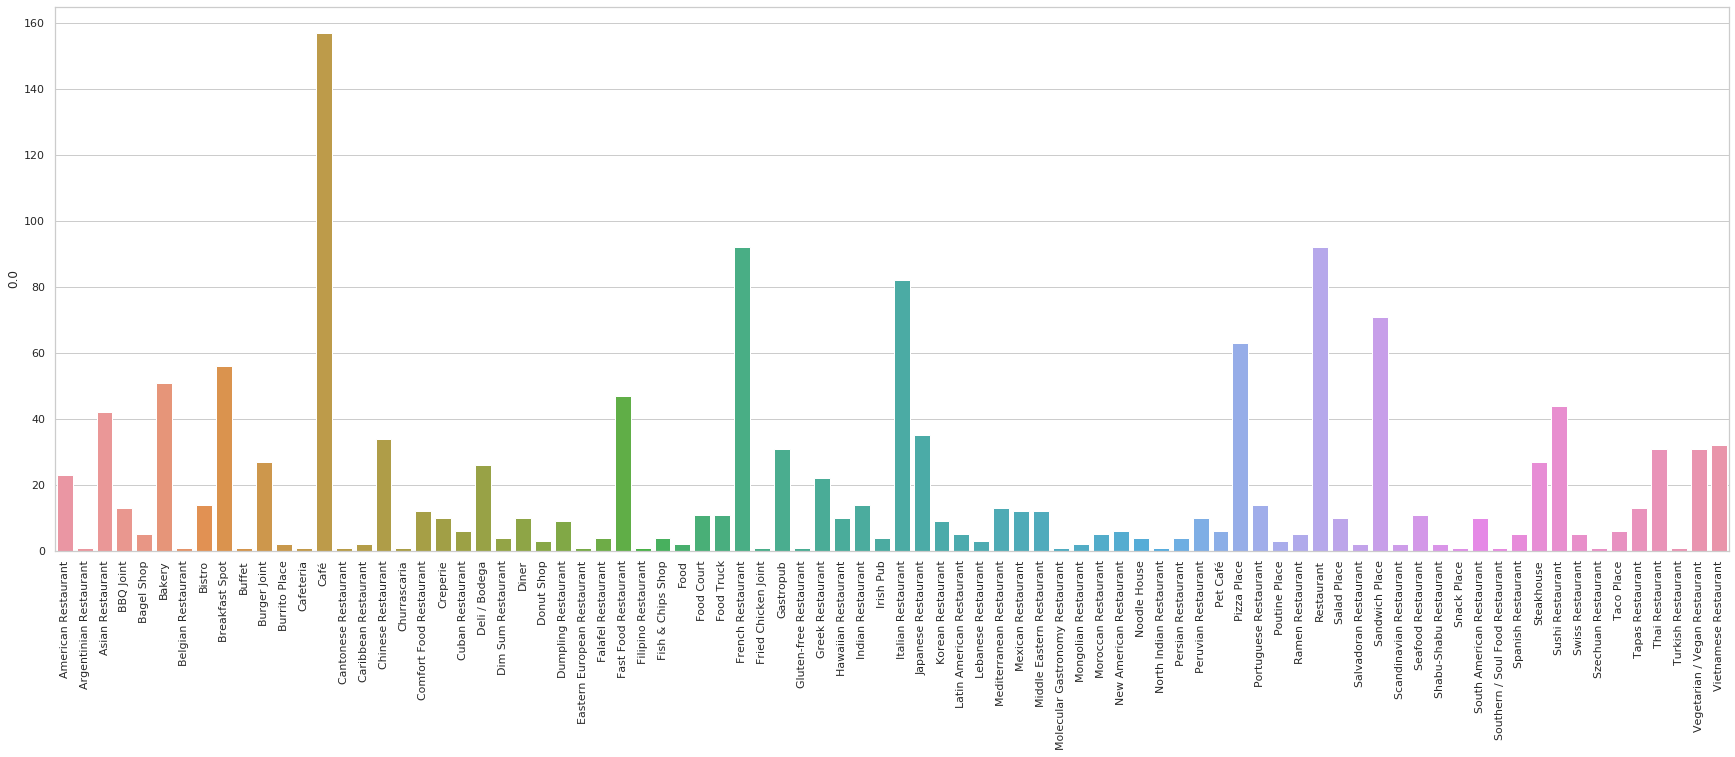

In [24]:
plot_bar(0)

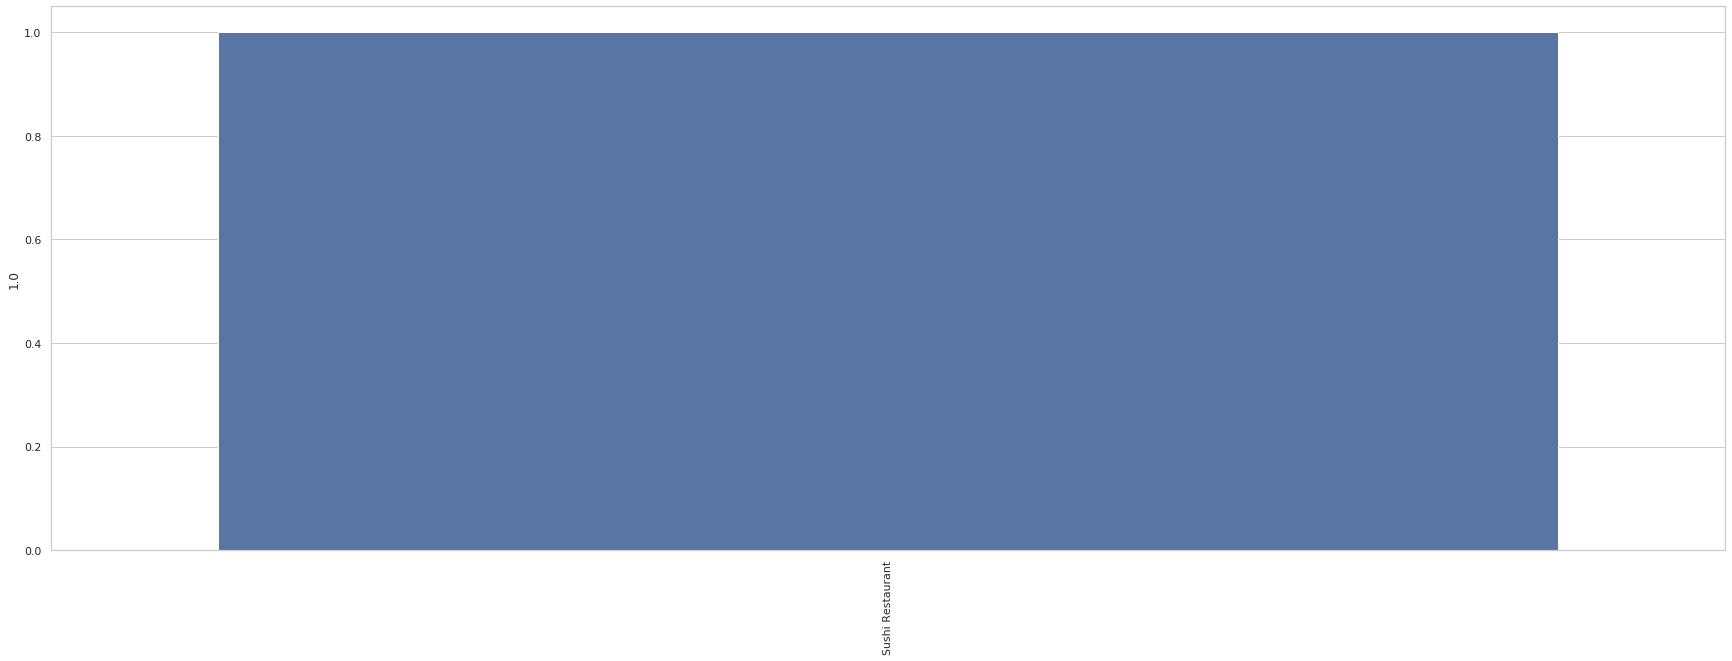

In [25]:
plot_bar(1)

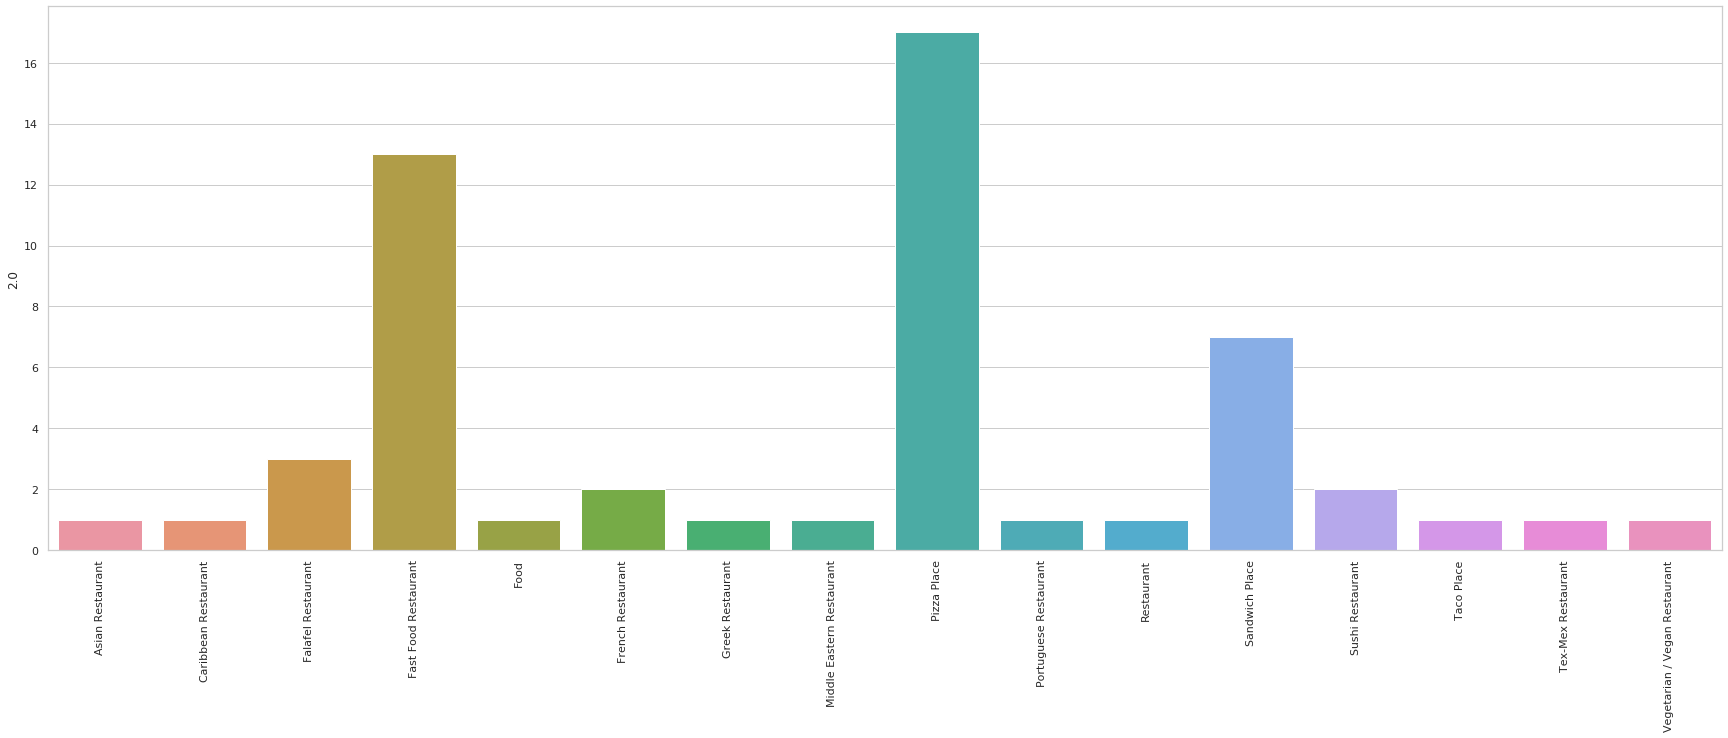

In [26]:
plot_bar(2)

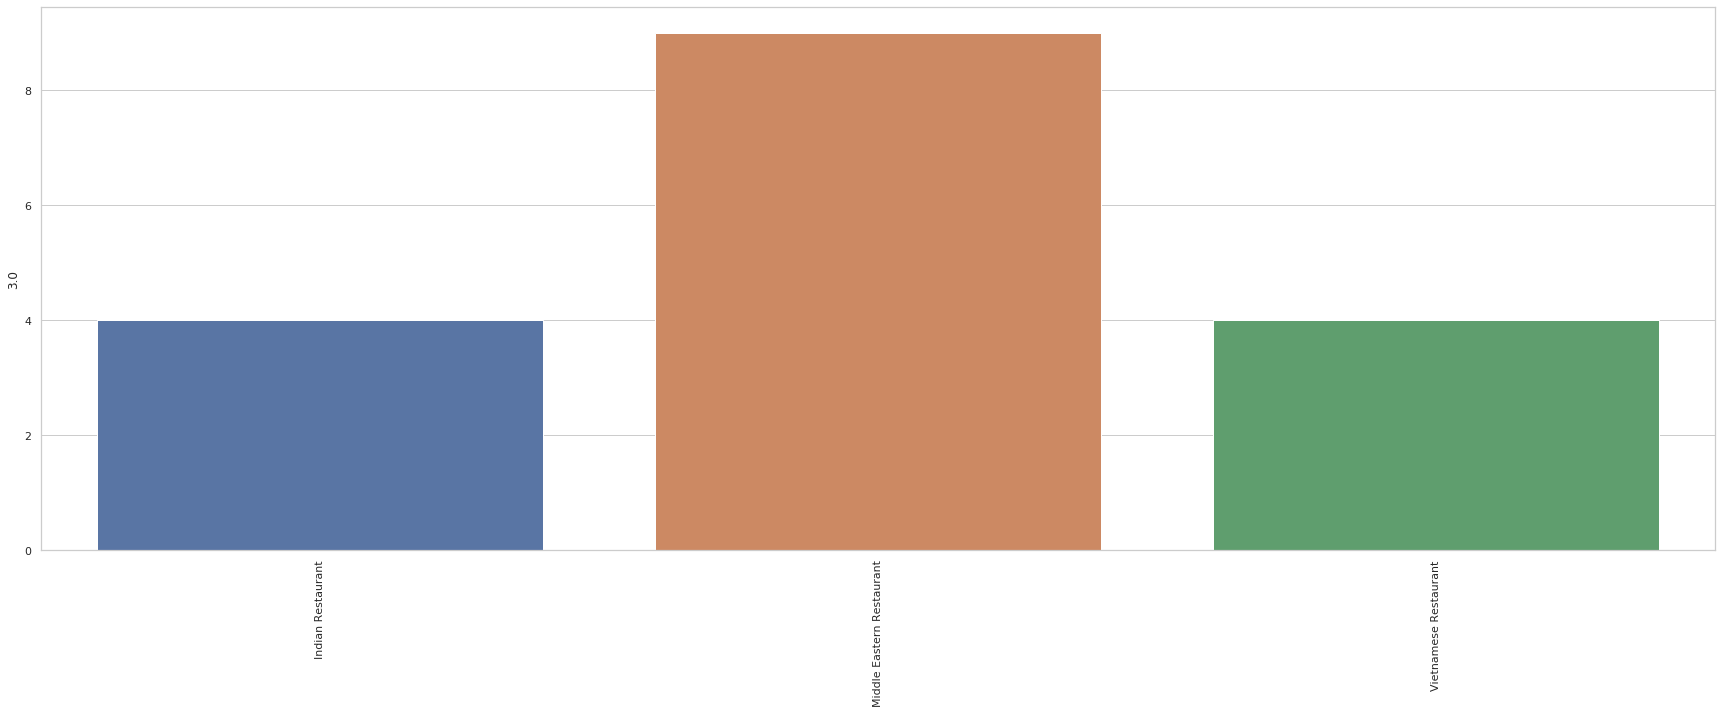

In [27]:
plot_bar(3)

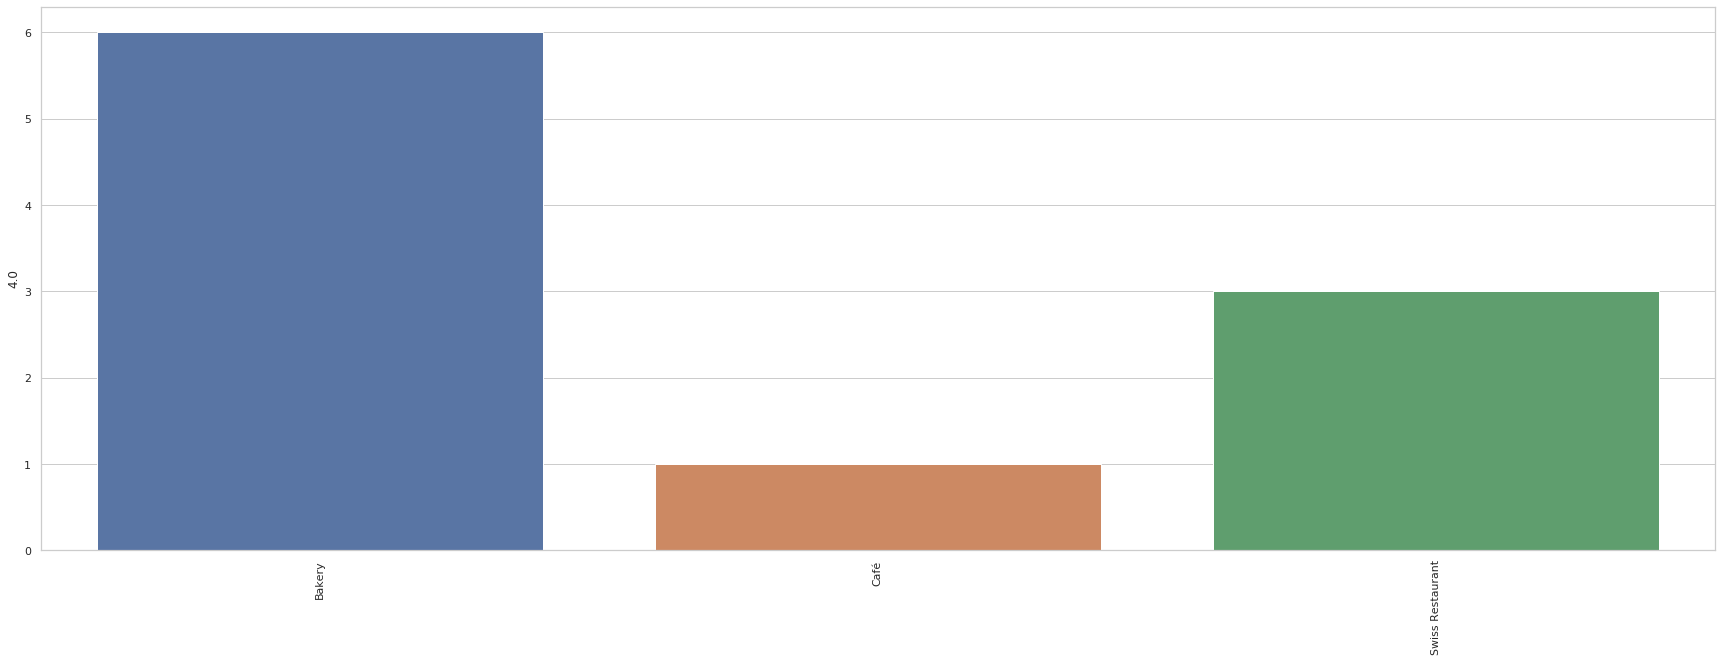

In [28]:
plot_bar(4)

<h2> Analyzing the Result </h2><a name = 'analyzeresult'>

[Table of Contents](#top)

With the clusters that we have, it is safe to assume that cluster 0 and 2 will be sufficient for us to say that this will be the places that we can setup an Asian Restaurant.

In [29]:
df_montreal_m

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,0,H1A,Pointe-aux-Trembles,Pointe-aux-Trembles,45.641666,-73.500401,2.0,Pizza Place,Fast Food Restaurant,Asian Restaurant,...,Eastern European Restaurant,Falafel Restaurant,Vietnamese Restaurant,Fish & Chips Shop,Deli / Bodega,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub
2,2,H3A,Downtown MontrealNorth,McGill University,45.504785,-73.577151,0.0,Sandwich Place,Café,Pizza Place,...,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Filipino Restaurant,Deli / Bodega
3,3,H4A,Notre-Dame-de-GrâceNortheast,Notre-Dame-de-GrâceNortheast,45.465174,-73.632219,0.0,Pizza Place,Asian Restaurant,Japanese Restaurant,...,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food,Dim Sum Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub
4,4,H5A,Place Bonaventure,Place Bonaventure,45.499444,-73.565000,0.0,Café,Sandwich Place,Restaurant,...,Comfort Food Restaurant,Bistro,Cuban Restaurant,Deli / Bodega,Fast Food Restaurant,French Restaurant,Gastropub,BBQ Joint,Asian Restaurant,Vegetarian / Vegan Restaurant
5,5,H7A,Duvernay-Est,Duvernay-Est,45.647219,-73.615238,2.0,Pizza Place,Vietnamese Restaurant,Fish & Chips Shop,...,Food,Deli / Bodega,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,118,H8Y,"Pierrefonds-RoxboroRoxboro, A Ma Baie, Cloverd...","Pierrefonds-RoxboroRoxboro, A Ma Baie, Cloverd...",45.504459,-73.782388,2.0,Fast Food Restaurant,Greek Restaurant,Pizza Place,...,Falafel Restaurant,Filipino Restaurant,Cuban Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub
120,120,H2Z,Downtown MontrealNortheast,Downtown MontrealNortheast,45.503480,-73.568489,0.0,Café,Restaurant,Sandwich Place,...,French Restaurant,Vegetarian / Vegan Restaurant,Food Court,Fast Food Restaurant,Italian Restaurant,Steakhouse,Cuban Restaurant,Peruvian Restaurant,Food Truck,Chinese Restaurant
121,121,H3Z,WestmountSouth,WestmountSouth,45.485719,-73.595699,0.0,Italian Restaurant,Diner,Bakery,...,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food,Deli / Bodega,Food Truck,Fried Chicken Joint,Gastropub,Gluten-free Restaurant
122,122,H4Z,Tour de la Bourse,Tour de la Bourse,45.500884,-73.561765,0.0,Café,French Restaurant,Restaurant,...,Fish & Chips Shop,New American Restaurant,Peruvian Restaurant,Comfort Food Restaurant,Gastropub,Salad Place,Italian Restaurant,BBQ Joint,Steakhouse,Burrito Place


In [30]:
mont_heatmap = df_mont_venue
mont_heatmap = pd.merge(mont_heatmap,df_montreal_m[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
mont_heatmap.drop(mont_heatmap[~mont_heatmap['Cluster Labels'].isin([0,2])].index, inplace=True)

In [31]:
mont_heatmap.head(10)

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,0,Pointe-aux-Trembles,45.641666,-73.500401,Subway,45.641076,-73.501334,Sandwich Place,2.0
1,1,Pointe-aux-Trembles,45.641666,-73.500401,PFK,45.642370,-73.503428,Fast Food Restaurant,2.0
2,2,Pointe-aux-Trembles,45.641666,-73.500401,Dic Ann’s,45.641219,-73.501674,Fast Food Restaurant,2.0
3,3,Pointe-aux-Trembles,45.641666,-73.500401,Thaï mix,45.642294,-73.502373,Asian Restaurant,2.0
4,4,Pointe-aux-Trembles,45.641666,-73.500401,Pizza Hut,45.641550,-73.503546,Pizza Place,2.0
5,5,Pointe-aux-Trembles,45.641666,-73.500401,Double Pizza,45.641987,-73.504305,Pizza Place,2.0
6,6,Pointe-aux-Trembles,45.641666,-73.500401,Kuy-To Sushi,45.642656,-73.504876,Sushi Restaurant,2.0
7,7,McGill University,45.504785,-73.577151,Café Humble Lion,45.503369,-73.575044,Café,0.0
8,8,McGill University,45.504785,-73.577151,Lola Rosa Café,45.507307,-73.575714,Vegetarian / Vegan Restaurant,0.0
9,9,McGill University,45.504785,-73.577151,Vua Sandwichs,45.504301,-73.572346,Sandwich Place,0.0


<h2> Heatmap of All Resttaurants in Clusters 0 and 2 </h2><a name = 'heatmap'></a>

[Table of Contents](#top)

In [32]:
from folium.plugins import HeatMap

venue_heat = folium.Map(location=[45.508888, -73.561668], zoom_start=11)
HeatMap(list(zip(mont_heatmap['Venue Latitude'],mont_heatmap['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(venue_heat)
for lat, lng, label in zip(mont_heatmap['Neighborhood Latitude'], mont_heatmap['Neighborhood Longitude'], mont_heatmap['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(venue_heat)
venue_heat

<h2> Heatmap of all the Asian Restaurants in Clusters 1 and 0 </h2><a name = 'asianheatmap'>


[Table of Contents](#top)

In [33]:
fil_res = mont_heatmap[mont_heatmap['Venue Category']=='Asian Restaurant']

fil_heat = folium.Map(location = [45.508888, -73.561668], zoom_start=11)
HeatMap(list(zip(fil_res['Venue Latitude'],fil_res['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(fil_heat)
for lat, lng, label in zip(fil_res['Neighborhood Latitude'], fil_res['Neighborhood Longitude'], fil_res['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(fil_heat)
fil_heat

Conditions for removing the Neighborhood:
* Number of Asian restaurants >30%
* Number of all restaurants >60% 
<br>


In [34]:
mont_all = mont_heatmap[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue')
target_count = int(0.6*len(mont_all))
print(mont_all.iloc[target_count])
mont_all.drop(mont_all[mont_all.Venue.values>7].index,inplace=True)
mont_all.columns=['all count']
mont_all.head()

Venue    9
Name: Côte-des-NeigesEast, dtype: int64


,all count
Neighborhood,
Duvernay-Est,1
Sainte-Dorothée,1
Laval-des-Rapides,1
Akwesasne Region1A0: Akwesasne,1
YUL,1


In [35]:
asian_count = mont_heatmap[mont_heatmap['Venue Category']=="Asian Restaurant"][['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue')
target_count = int(0.3*len(asian_count))
print(asian_count.iloc[target_count])
asian_count.drop(asian_count[asian_count.Venue.values>1].index,inplace=True)
asian_count.columns = ['asian count']
asian_count.head()

Venue    1
Name: Kirkland, dtype: int64


,asian count
Neighborhood,
AhuntsicCentral,1
RosemontCentral,1
Pointe-aux-Trembles,1
Place Bonaventure,1
Notre-Dame-de-GrâceSouthwest,1


In [36]:
lowdensity = asian_count.join(mont_all)
lowdensity.index.values

array(['AhuntsicCentral', 'RosemontCentral', 'Pointe-aux-Trembles',
       'Place Bonaventure', 'Notre-Dame-de-GrâceSouthwest',
       'Notre-Dame-de-GrâceNortheast', 'Montréal-NordNorth', 'Kirkland',
       'MercierWest', 'AuteuilWest', 'AuteuilSouth', 'AuteuilNortheast',
       'AhuntsicSouthwest', 'AhuntsicSoutheast', 'AhuntsicNorth',
       'AhuntsicEast', 'WestmountNorth'], dtype=object)

In [37]:
recommend = df_montreal
recommend.drop(recommend[~recommend['Neighborhood'].isin(lowdensity.index.values)].index, inplace=True)
recommend

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,0,H1A,Pointe-aux-Trembles,Pointe-aux-Trembles,45.641666,-73.500401
3,3,H4A,Notre-Dame-de-GrâceNortheast,Notre-Dame-de-GrâceNortheast,45.465174,-73.632219
4,4,H5A,Place Bonaventure,Place Bonaventure,45.499444,-73.565000
8,8,H2B,AhuntsicNorth,AhuntsicNorth,45.555235,-73.668203
10,10,H4B,Notre-Dame-de-GrâceSouthwest,Notre-Dame-de-GrâceSouthwest,45.465174,-73.632219
15,15,H2C,AhuntsicCentral,AhuntsicCentral,45.555235,-73.668203
26,26,H1G,Montréal-NordNorth,Montréal-NordNorth,45.501689,-73.567256
37,37,H7H,AuteuilWest,AuteuilWest,45.612064,-73.743434
43,43,H7J,AuteuilNortheast,AuteuilNortheast,45.612064,-73.743434
44,44,H9J,Kirkland,Kirkland,45.456041,-73.862334


In [38]:
popular_neighbor = df_mont_venue[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue', ascending=False).head(30).index.values
popular_neighbor

array(['Saint-LaurentEast', 'Place Desjardins', 'Montréal-NordNorth',
       'Downtown MontrealEast', 'Downtown MontrealSouthwest',
       'Downtown MontrealNortheast', 'Reserved0H0: Santa Claus',
       'Concordia University', 'Old Montreal', 'Tour de la Bourse',
       'Plateau Mont-RoyalWest', 'Plateau Mont-RoyalNorth',
       'Plateau Mont-RoyalNorth Central',
       'Plateau Mont-RoyalSouth Central', 'Place Bonaventure',
       'Plateau Mont-RoyalSoutheast', 'VerdunNorth', 'VerdunSouth',
       'Petite-PatrieSouthwest', 'Petite-PatrieNortheast',
       'WestmountNorth', 'Petite-Bourgogne', 'Maisonneuve', 'Kirkland',
       'McGill University', 'VilleraySoutheast',
       'Sainte-Anne-De-Bellevue', 'VillerayNortheast', 'LaSalleSoutheast',
       'LaSalleNorthwest'], dtype=object)

In [39]:
toplatlng = df_montreal[['Neighborhood','Latitude','Longitude']][df_montreal['Neighborhood'].isin(popular_neighbor)].reset_index()
toplatlng

,index,Neighborhood,Latitude,Longitude
0,4,Place Bonaventure,45.499444,-73.565000
1,26,Montréal-NordNorth,45.501689,-73.567256
2,44,Kirkland,45.456041,-73.862334
3,115,WestmountNorth,45.477638,-73.604446


In [40]:
from math import sin, cos, sqrt, atan2, radians

def distanceInKM(la1,lo1,la2,lo2):
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dis = R * c
    return round(dis,4)

print("Result:", distanceInKM(toplatlng.iloc[3]['Latitude'],toplatlng.iloc[3]['Longitude'],toplatlng.iloc[0]['Latitude'],toplatlng.iloc[0]['Longitude']))

Result: 3.9172


In [41]:
recommend.reset_index(inplace = True)

In [42]:
recommend.drop(columns=["index","Unnamed: 0","PostalCode", "Borough"], inplace=True)

In [43]:
recommend

,Neighborhood,Latitude,Longitude
0,Pointe-aux-Trembles,45.641666,-73.500401
1,Notre-Dame-de-GrâceNortheast,45.465174,-73.632219
2,Place Bonaventure,45.499444,-73.565000
3,AhuntsicNorth,45.555235,-73.668203
4,Notre-Dame-de-GrâceSouthwest,45.465174,-73.632219
5,AhuntsicCentral,45.555235,-73.668203
6,Montréal-NordNorth,45.501689,-73.567256
7,AuteuilWest,45.612064,-73.743434
8,AuteuilNortheast,45.612064,-73.743434
9,Kirkland,45.456041,-73.862334


In [44]:
for i in toplatlng.index:
    recommend[toplatlng.iloc[i]['Neighborhood']] = recommend.apply(lambda x : distanceInKM(toplatlng.iloc[i]['Latitude'],toplatlng.iloc[i]['Longitude'],x['Latitude'],x['Longitude']),axis=1)

In [45]:
recommend.head()

,Neighborhood,Latitude,Longitude,Place Bonaventure,Montréal-NordNorth,Kirkland,WestmountNorth
0,Pointe-aux-Trembles,45.641666,-73.500401,16.5997,16.4168,34.9444,19.9633
1,Notre-Dame-de-GrâceNortheast,45.465174,-73.632219,6.4816,6.4932,17.9814,2.5719
2,Place Bonaventure,45.499444,-73.565000,0.0000,0.3054,23.6871,3.9172
3,AhuntsicNorth,45.555235,-73.668203,10.1579,9.8665,18.7283,9.9593
4,Notre-Dame-de-GrâceSouthwest,45.465174,-73.632219,6.4816,6.4932,17.9814,2.5719


In [46]:
nearPlaceBonaventure = recommend.sort_values(by=['Place Bonaventure']).iloc[:,:3].head().set_index('Neighborhood')
nearPlaceBonaventure

,Latitude,Longitude
Neighborhood,,
Place Bonaventure,45.499444,-73.565000
Montréal-NordNorth,45.501689,-73.567256
WestmountNorth,45.477638,-73.604446
RosemontCentral,45.536080,-73.591702
Notre-Dame-de-GrâceNortheast,45.465174,-73.632219


In [47]:
nearMontrealNorth = recommend.sort_values(by=['Montréal-NordNorth']).iloc[:,:3].head().set_index('Neighborhood')
nearMontrealNorth

,Latitude,Longitude
Neighborhood,,
Montréal-NordNorth,45.501689,-73.567256
Place Bonaventure,45.499444,-73.565000
WestmountNorth,45.477638,-73.604446
RosemontCentral,45.536080,-73.591702
Notre-Dame-de-GrâceNortheast,45.465174,-73.632219


In [48]:
nearKirkland = recommend.sort_values(by=['Kirkland']).iloc[:,:3].head().set_index('Neighborhood')
nearKirkland

,Latitude,Longitude
Neighborhood,,
Kirkland,45.456041,-73.862334
Notre-Dame-de-GrâceNortheast,45.465174,-73.632219
Notre-Dame-de-GrâceSouthwest,45.465174,-73.632219
AhuntsicSoutheast,45.555235,-73.668203
AhuntsicNorth,45.555235,-73.668203


In [49]:
nearWestmountNorth = recommend.sort_values(by=['WestmountNorth']).iloc[:,:3].head().set_index('Neighborhood')
nearWestmountNorth

,Latitude,Longitude
Neighborhood,,
WestmountNorth,45.477638,-73.604446
Notre-Dame-de-GrâceNortheast,45.465174,-73.632219
Notre-Dame-de-GrâceSouthwest,45.465174,-73.632219
Place Bonaventure,45.499444,-73.565000
Montréal-NordNorth,45.501689,-73.567256


<h2> The Final Neighborhood For Recommendation </h2><a name = 'finalneighborhood'>

[Table of Contents](#top)

In [50]:
final=nearPlaceBonaventure.append(nearMontrealNorth).append(nearKirkland).append(nearWestmountNorth).reset_index()
final.drop_duplicates(inplace=True)
final.reset_index(inplace=True)
final.drop(columns=['index'],inplace=True)
final

,Neighborhood,Latitude,Longitude
0,Place Bonaventure,45.499444,-73.565000
1,Montréal-NordNorth,45.501689,-73.567256
2,WestmountNorth,45.477638,-73.604446
3,RosemontCentral,45.536080,-73.591702
4,Notre-Dame-de-GrâceNortheast,45.465174,-73.632219
5,Kirkland,45.456041,-73.862334
6,Notre-Dame-de-GrâceSouthwest,45.465174,-73.632219
7,AhuntsicSoutheast,45.555235,-73.668203
8,AhuntsicNorth,45.555235,-73.668203


In [54]:
final.shape

(9, 3)

In [51]:
finalMap = folium.Map(location=[45.508888, -73.561668], zoom_start=11)

# add markers to map
for lat, lng, label in zip(final['Latitude'], final['Longitude'], final['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(finalMap)  
    
finalMap

<h2> Conclusion </h2><a name = 'conclusion'></a>

[Table of Contents](#top)

Number of Neighborhood = 124
Number of Restaurants or Venues = 1543
Number of Recommended Places = 9

Among the top three are:

|Neighborhood|Latitude|Longitude|
|---|---|---|
|Place Bonaventure|45.499444|73.565000|
|Montréal-NordNorth|45.501689|-73.567256|
|WestmountNorth|45.477638|-73.604446|
|RosemontCentral|45.536080|-73.591702|


Though this is not really conclusive due to some factors missing like: population, accessibility, how expensive the rent on each top neighborhood and much more.